# Gaussian Process: Basics - Synthetic Data

In this notebook, I have:
1. Generated synthetic 1D data
2. Fit a Gaussian Process
3. Visualized predictions with uncertainty
4. Understanding of different kernels
5. Sampling from GP prior and posterior

**What is a Gaussian Process?**
- A GP defines a **distribution over functions**
- Every point has a Gaussian distribution
- Any finite set of points has a joint Gaussian distribution
- Key feature: **Uncertainty quantification!**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('..')

from src.gp_core.kernels import RBFKernel, MaternKernel, PeriodicKernel
from src.gp_core.gaussian_process import GaussianProcess

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

np.random.seed(42)

print("Imports successful!")

Imports successful!


## 1. Generate Synthetic Data

Created a simple 1D function with noise to test our GP.

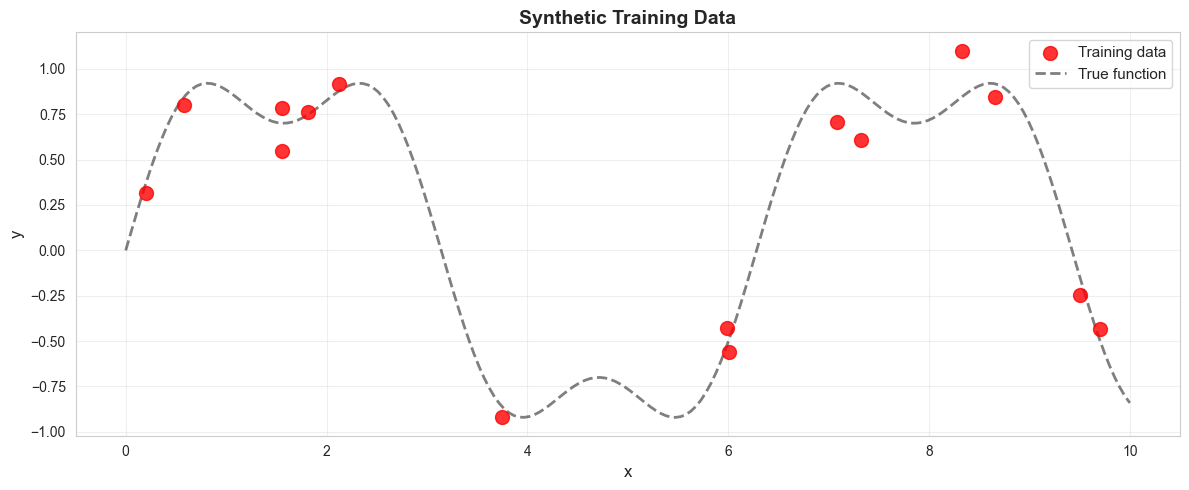

Training data: 15 points
X range: [0.21, 9.70]


In [4]:
# True underlying function (unknown to GP)
def true_function(x):
    """A non-linear function with some complexity."""
    return np.sin(x) + 0.3 * np.sin(3 * x)

# Generate training data
n_train = 15
X_train = np.random.uniform(0, 10, n_train).reshape(-1, 1)
y_train = true_function(X_train.flatten()) + 0.1 * np.random.randn(n_train)

# Test points for visualization
X_test = np.linspace(0, 10, 200).reshape(-1, 1)
y_true = true_function(X_test.flatten())

# Plot the data
plt.figure(figsize=(12, 5))
plt.scatter(X_train, y_train, c='red', s=100, alpha=0.8, label='Training data', zorder=3)
plt.plot(X_test, y_true, 'k--', alpha=0.5, label='True function', linewidth=2)
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('Synthetic Training Data', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Training data: {n_train} points")
print(f"X range: [{X_train.min():.2f}, {X_train.max():.2f}]")

## 2. Fitting Gaussian Process with RBF Kernel

The RBF (Radial Basis Function) kernel is a popular choice:

$$k(x, x') = \sigma^2 \exp\left(-\frac{||x - x'||^2}{2l^2}\right)$$

Parameters:
- `length_scale` ($l$): How far you need to move before values become uncorrelated
- `variance` ($\sigma^2$): Overall scale of the function

In [5]:
# Creating and fitting GP
kernel = RBFKernel(length_scale=1.0, variance=1.0)
gp = GaussianProcess(kernel=kernel, noise=0.01)

print(f"Before fitting: {gp}")
gp.fit(X_train, y_train)
print(f"After fitting: {gp}")

# predictions
y_pred, y_std = gp.predict(X_test, return_std=True)

print(f"\nLog Marginal Likelihood: {gp.log_marginal_likelihood():.3f}")
print(f"Mean prediction: {y_pred.mean():.3f}")
print(f"Mean uncertainty: {y_std.mean():.3f}")

Before fitting: GaussianProcess(kernel=RBFKernel(length_scale=1.000, variance=1.000), noise=1.0e-02, not fitted)
After fitting: GaussianProcess(kernel=RBFKernel(length_scale=1.000, variance=1.000), noise=1.0e-02, fitted)

Log Marginal Likelihood: -8.909
Mean prediction: 0.083
Mean uncertainty: 0.184


/Users/ovi/Desktop/GP_and_BO/notebooks/../src/gp_core/gaussian_process.py:121: RuntimeWarning: divide by zero encountered in matmul
  mean = K_test_train @ self.alpha
/Users/ovi/Desktop/GP_and_BO/notebooks/../src/gp_core/gaussian_process.py:121: RuntimeWarning: overflow encountered in matmul
  mean = K_test_train @ self.alpha
/Users/ovi/Desktop/GP_and_BO/notebooks/../src/gp_core/gaussian_process.py:121: RuntimeWarning: invalid value encountered in matmul
  mean = K_test_train @ self.alpha


## 3. Visualizing GP Predictions with Uncertainty

The key feature of GPs: **uncertainty quantification**!

- Dark region: ±1 std (68% confidence)
- Light region: ±2 std (95% confidence)

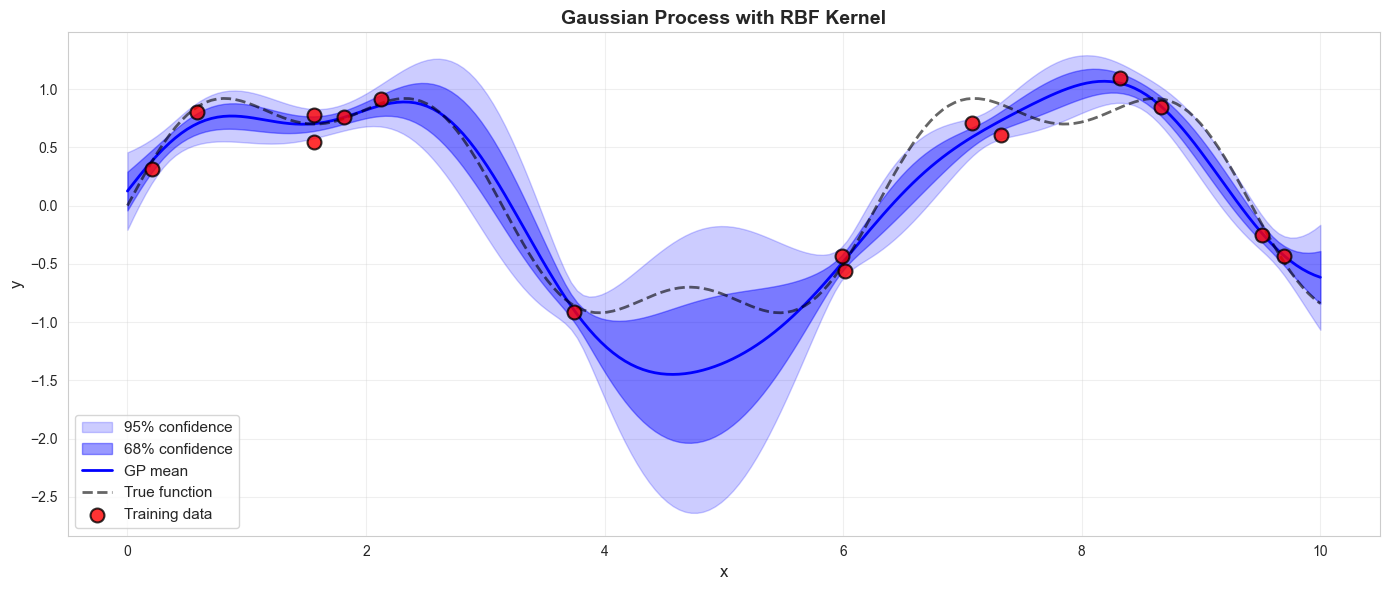

In [8]:
def plot_gp_predictions(X_train, y_train, X_test, y_pred, y_std, y_true=None, title='GP Predictions'):
    """GP visualization."""
    plt.figure(figsize=(14, 6))
    
    # Plot uncertainty bands
    plt.fill_between(X_test.flatten(), 
                     y_pred - 2*y_std, 
                     y_pred + 2*y_std, 
                     alpha=0.2, color='blue', label='95% confidence')
    plt.fill_between(X_test.flatten(), 
                     y_pred - y_std, 
                     y_pred + y_std, 
                     alpha=0.4, color='blue', label='68% confidence')
    
    # Plot predictions
    plt.plot(X_test, y_pred, 'b-', linewidth=2, label='GP mean', zorder=2)
    
    # Plot true function if available
    if y_true is not None:
        plt.plot(X_test, y_true, 'k--', alpha=0.6, linewidth=2, label='True function')
    
    # Plot training data
    plt.scatter(X_train, y_train, c='red', s=100, alpha=0.8, 
                edgecolors='black', linewidths=1.5, label='Training data', zorder=3)
    
    plt.xlabel('x', fontsize=12)
    plt.ylabel('y', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend(fontsize=11, loc='best')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_gp_predictions(X_train, y_train, X_test, y_pred, y_std, y_true, 
                   title='Gaussian Process with RBF Kernel')

## 4. Effect of Kernel Hyperparameters

Let's see how `length_scale` affects the predictions:
- **Small length_scale**: Assumes function changes quickly → wiggly, overfits
- **Large length_scale**: Assumes function changes slowly → too smooth, underfits

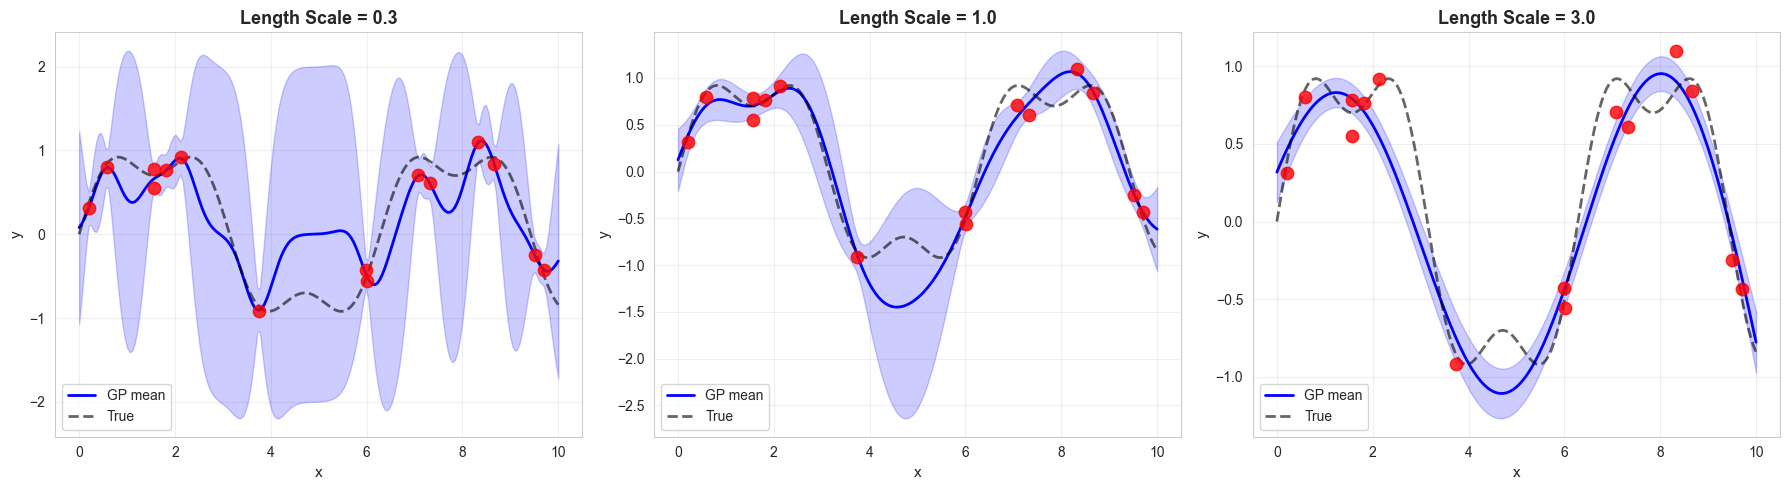

Length Scale Effects:
  • Small (0.3): Wiggly, overfits - assumes rapid changes
  • Medium (1.0): Balanced - good generalization
  • Large (3.0): Too smooth - underfits, assumes slow changes


In [9]:
length_scales = [0.3, 1.0, 3.0]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, ls in enumerate(length_scales):
    # Fit GP with different length scales
    kernel = RBFKernel(length_scale=ls, variance=1.0)
    gp = GaussianProcess(kernel=kernel, noise=0.01)
    gp.fit(X_train, y_train)
    
    y_pred, y_std = gp.predict(X_test, return_std=True)
    
    # Plot
    ax = axes[i]
    ax.fill_between(X_test.flatten(), y_pred - 2*y_std, y_pred + 2*y_std, 
                     alpha=0.2, color='blue')
    ax.plot(X_test, y_pred, 'b-', linewidth=2, label='GP mean')
    ax.plot(X_test, y_true, 'k--', alpha=0.6, linewidth=2, label='True')
    ax.scatter(X_train, y_train, c='red', s=80, alpha=0.8, zorder=3)
    
    ax.set_title(f'Length Scale = {ls}', fontsize=13, fontweight='bold')
    ax.set_xlabel('x', fontsize=11)
    ax.set_ylabel('y', fontsize=11)
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("Length Scale Effects:")
print("  • Small (0.3): Wiggly, overfits - assumes rapid changes")
print("  • Medium (1.0): Balanced - good generalization")
print("  • Large (3.0): Too smooth - underfits, assumes slow changes")

## 5. Different Kernel Comparisons

Let's compare different kernels:
- **RBF**: Infinitely smooth, most flexible
- **Matern (ν=1.5)**: Once differentiable, less smooth
- **Matern (ν=2.5)**: Twice differentiable, smoother than ν=1.5

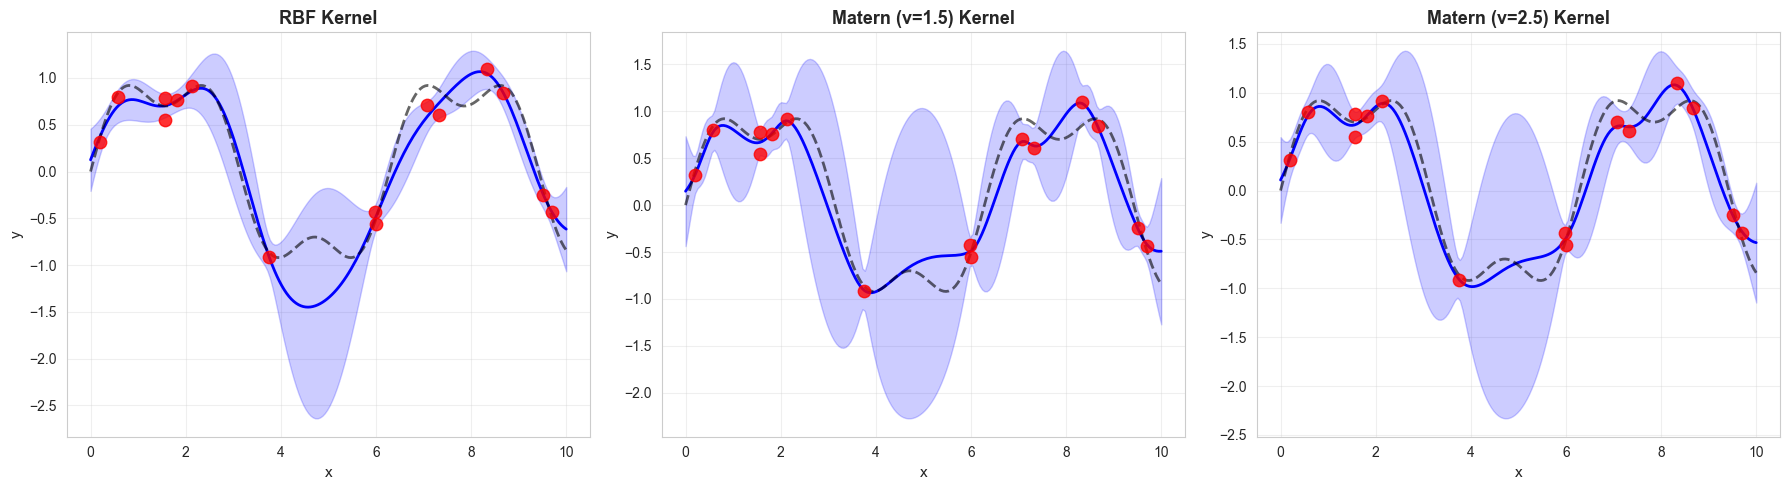

In [10]:
kernels = [
    ('RBF', RBFKernel(length_scale=1.0, variance=1.0)),
    ('Matern (ν=1.5)', MaternKernel(length_scale=1.0, variance=1.0, nu=1.5)),
    ('Matern (ν=2.5)', MaternKernel(length_scale=1.0, variance=1.0, nu=2.5)),
]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (name, kernel) in enumerate(kernels):
    gp = GaussianProcess(kernel=kernel, noise=0.01)
    gp.fit(X_train, y_train)
    
    y_pred, y_std = gp.predict(X_test, return_std=True)
    
    ax = axes[i]
    ax.fill_between(X_test.flatten(), y_pred - 2*y_std, y_pred + 2*y_std, 
                     alpha=0.2, color='blue')
    ax.plot(X_test, y_pred, 'b-', linewidth=2)
    ax.plot(X_test, y_true, 'k--', alpha=0.6, linewidth=2)
    ax.scatter(X_train, y_train, c='red', s=80, alpha=0.8, zorder=3)
    
    ax.set_title(f'{name} Kernel', fontsize=13, fontweight='bold')
    ax.set_xlabel('x', fontsize=11)
    ax.set_ylabel('y', fontsize=11)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Sampling from GP Prior and Posterior

GPs define distributions over **functions**, not just values.

- **Prior**: Random functions before seeing data
- **Posterior**: Functions constrained by data

/Users/ovi/Desktop/GP_and_BO/notebooks/../src/gp_core/gaussian_process.py:134: RuntimeWarning: divide by zero encountered in matmul
  cov = K_test_test - v.T @ v
/Users/ovi/Desktop/GP_and_BO/notebooks/../src/gp_core/gaussian_process.py:134: RuntimeWarning: overflow encountered in matmul
  cov = K_test_test - v.T @ v
/Users/ovi/Desktop/GP_and_BO/notebooks/../src/gp_core/gaussian_process.py:134: RuntimeWarning: invalid value encountered in matmul
  cov = K_test_test - v.T @ v


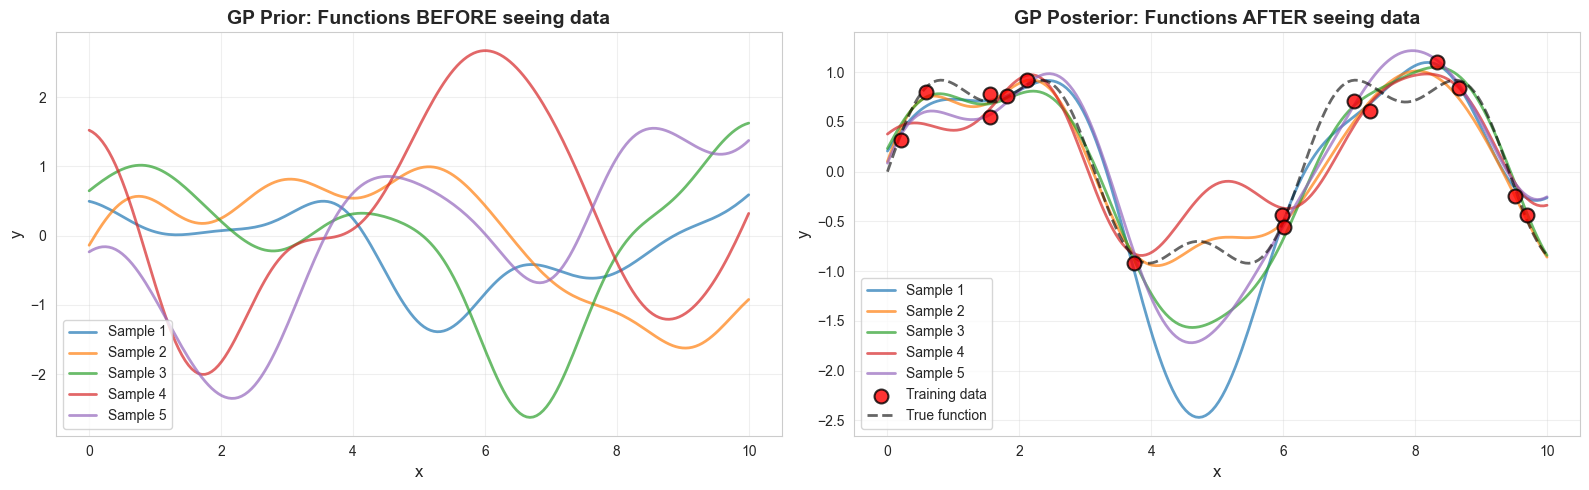


 Key Observations:
  • Prior: Random smooth functions (no data constraints)
  • Posterior: Functions pass through/near training data
  • Uncertainty high- far from data, low- near data


In [13]:
# Sample from PRIOR (before seeing data)
kernel = RBFKernel(length_scale=1.0, variance=1.0)
gp_prior = GaussianProcess(kernel=kernel, noise=0.01)

X_sample = np.linspace(0, 10, 200).reshape(-1, 1)
prior_samples = gp_prior.sample_y(X_sample, n_samples=5, random_state=42)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Prior samples
ax = axes[0]
for i, sample in enumerate(prior_samples):
    ax.plot(X_sample, sample, alpha=0.7, linewidth=2, label=f'Sample {i+1}')
ax.set_title('GP Prior: Functions BEFORE seeing data', fontsize=14, fontweight='bold')
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

# Sample from POSTERIOR (after seeing data)
gp_posterior = GaussianProcess(kernel=kernel, noise=0.01)
gp_posterior.fit(X_train, y_train)

posterior_samples = gp_posterior.sample_y(X_sample, n_samples=5, random_state=42)

ax = axes[1]
for i, sample in enumerate(posterior_samples):
    ax.plot(X_sample, sample, alpha=0.7, linewidth=2, label=f'Sample {i+1}')
ax.scatter(X_train, y_train, c='red', s=100, alpha=0.8, zorder=3, 
          edgecolors='black', linewidths=1.5, label='Training data')
ax.plot(X_sample, y_true, 'k--', alpha=0.6, linewidth=2, label='True function')
ax.set_title('GP Posterior: Functions AFTER seeing data', fontsize=14, fontweight='bold')
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n Key Observations:")
print("  • Prior: Random smooth functions (no data constraints)")
print("  • Posterior: Functions pass through/near training data")
print("  • Uncertainty high- far from data, low- near data")

## Summary

1. GPs provide **uncertainty estimates** (crucial for Bayesian Optimization)
2. Kernels encode assumptions about function smoothness
3. Length scale controls how wiggly the function can be
4. Can optimize hyperparameters automatically
5. GPs define distributions over functions (sample infinite possibilities)

**Next steps:**
- Building Bayesian Optimization on top of this Gaussian Proccess
- Using acquisition functions to decide where to sample next
- Applying to hyperparameter tuning!